In [56]:
#Import pandas and numpy for data manipulation and computation
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os

#When combined, this dataset becomes quite large, grabbing the compressed sparse row
    #matrix function from scipy
from scipy.sparse import csr_matrix, hstack

#Import the scikit-learn library for modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [57]:
#set the directory for the data, since this notebook is in the root for the conda env, I stashed all
    #the data into a directory called Data
datadir = 'Data/'

#Now read in all the data
#First, sniggity snag the data gender_age_train
    #and set the index column
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')

#Do the same for gender_age_test
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')

#And again for phone_brand_device_model
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))

#Get rid of duplicate device ids in phone, keep the first one that occurs
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')

#Same for events, and correctly set the datatype for the timestamp feature
    #to be a date-time YYYY-MM-DD 00:HH:MM
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')

#Same deal for app_events but not the is_installed feature
    #the idea is that if the app is active, it is installed
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})

#Same for label_categories
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

#Revisit this later
#labelcats = pd.read_csv(os.path.join(datadir,'label_categories.csv'))

In [58]:
#Look at the first 5 tuples for the gender age group training set
gatrain.head(n=5)

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38
-4938849341048082022,M,30,M29-31
245133531816851882,M,30,M29-31


In [59]:
#Look at the first 5 for the devices and their associated brands and models
phone.head(n=5)

,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2


In [60]:
#Look at the first 5 for the phone events data set
events.head(n=5)

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [61]:
#Look at the first 5 for the table that ties the application id to the mobile event
appevents.head(n=5)

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


In [62]:
#Look at the table that associates mobile applications
applabels.head(n=5)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [63]:
#Using one-hot encoding, create two columns that show which train or test set row a particular device_id belongs to
    #one-hot encoding is for some models that cannot encode a n way choice properly
#http://stackoverflow.com/questions/17469835/one-hot-encoding-for-machine-learning
gatrain['trainrow'] = np.arange(gatrain.shape[0])

gatest['testrow'] = np.arange(gatest.shape[0])

In [64]:
#Because the dataset information is from Chinese users, many of the phone brands and models are in Hanzi, not english
    #UTF-8 Unicode
#Start some preprocessing from scikit-learn to transform the labels
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])

#Propogate the associated phone brands to both the train and test sets given
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']

#Create compressed sparse row matrices for both train and test
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))

Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))

#Double check the dimensions of the two csr matrices
print('feature matrix shapes: train {}, test {}'.format(Xtr_brand.shape, Xte_brand.shape))

feature matrix shapes: train (74645, 131), test (112071, 131)


In [65]:
#Have a look at the top 5 tuples for the gatrain dataset to look at the encoded brands
gatrain.head()

,gender,age,group,trainrow,brand
device_id,,,,,
-8076087639492063270,M,35,M32-38,0,51
-2897161552818060146,M,35,M32-38,1,51
-8260683887967679142,M,35,M32-38,2,51
-4938849341048082022,M,30,M29-31,3,51
245133531816851882,M,30,M29-31,4,51


In [66]:
#Many of the cellphone models are also Hanzi, not English characters (pinyin)
#Use the same type of preprocessing to transform the models into categorical levels represented numerically
modelencoder = LabelEncoder().fit(phone.phone_brand.str.cat(phone.device_model))
phone['model'] = modelencoder.transform(phone.phone_brand.str.cat(phone.device_model))

#Propogate the phone models the same way as the brand
gatrain['model'] = phone['model']
gatest['model'] = phone['model']

#Same thing with the compressed sparse row matrices as done for the brands
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))

#And again with double checking the dimensions
print('feature matrix shapes: train {}, test {}'.format(Xtr_model.shape, Xte_model.shape))

feature matrix shapes: train (74645, 1667), test (112071, 1667)


In [67]:
#Take a look at gatrain again to see the new numerical levels for models
gatrain.head()

,gender,age,group,trainrow,brand,model
device_id,,,,,,
-8076087639492063270,M,35,M32-38,0,51,843
-2897161552818060146,M,35,M32-38,1,51,843
-8260683887967679142,M,35,M32-38,2,51,843
-4938849341048082022,M,30,M29-31,3,51,865
245133531816851882,M,30,M29-31,4,51,847


In [68]:
#Do the same kind of transformation to the app_ids
applabelenc = LabelEncoder().fit(appevents.app_id)
appevents['app'] = applabelenc.transform(appevents.app_id)

#Find the number of apps/levels
napps = len(applabelenc.classes_)

#Merging all the tables together becomes massive
#Merge and group by device ids and the number of times the app was used such that
    #The id, app, and size is what makes each tuple unique
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())


In [69]:
deviceapps.head(n=10)

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN
5,-9222956879900151005,1848,32,21594.0,NaN
6,-9222956879900151005,2236,28,21594.0,NaN
7,-9222956879900151005,2350,28,21594.0,NaN
8,-9222956879900151005,2626,27,21594.0,NaN
9,-9222956879900151005,3384,30,21594.0,NaN


In [70]:
#Drop the tuples where trainrow has an NA
data = deviceapps.dropna(subset=['trainrow'])

#Same thing with the compressed sparse row matrices as before
Xtr_app = csr_matrix((np.ones(data.shape[0]), (data.trainrow, data.app)), 
                      shape=(gatrain.shape[0],napps))

#Drop the tuples where testrow has an NA
data = deviceapps.dropna(subset=['testrow'])

Xte_app = csr_matrix((np.ones(data.shape[0]), (data.testrow, data.app)), 
                      shape=(gatest.shape[0],napps))

print('feature matrix shapes: train {}, test {}'.format(Xtr_app.shape, Xte_app.shape))

feature matrix shapes: train (74645, 19237), test (112071, 19237)


In [71]:
data.head()

,device_id,app,size,trainrow,testrow
72,-9222661944218806987,1867,3,NaN,13612.0
73,-9222661944218806987,7519,8,NaN,13612.0
74,-9222661944218806987,7843,1,NaN,13612.0
75,-9222661944218806987,8704,4,NaN,13612.0
76,-9222661944218806987,10000,1,NaN,13612.0


In [72]:
#From the appevents dataset grab the location feature vector from each unique id
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = applabelenc.transform(applabels.app_id)


labelencoder = LabelEncoder().fit(applabels.label_id)

applabels['label'] = labelencoder.transform(applabels.label_id)

nlabels = len(labelencoder.classes_)
print('Number of classes/nlabels: {}'.format(nlabels))

Number of classes/nlabels: 492


In [73]:
#Group and aggregate the devices and
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                #Make sure to use left joins here
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [74]:
data = devicelabels.dropna(subset=['trainrow'])

Xtr_label = csr_matrix((np.ones(data.shape[0]), (data.trainrow, data.label)), 
                      shape=(gatrain.shape[0],nlabels))

data = devicelabels.dropna(subset=['testrow'])

Xte_label = csr_matrix((np.ones(data.shape[0]), (data.testrow, data.label)), 
                      shape=(gatest.shape[0],nlabels))

print('feature matrix shapes: train {}, test {}'.format(Xtr_label.shape, Xte_label.shape))

feature matrix shapes: train (74645, 492), test (112071, 492)


In [75]:
#Stack the csr's created earlier into new test and train sets
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')

print('Final matrix shapes: train {}, test {}'.format(Xtrain.shape, Xtest.shape))

Final matrix shapes: train (74645, 21527), test (112071, 21527)


In [76]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)

nclasses = len(targetencoder.classes_)
print('Number of features being used for modelling: {}'.format(nclasses))

Number of features being used for modelling: 12


In [77]:
def score(clf, random_state = 0):
    
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    
    pred = np.zeros((y.shape[0],nclasses))
    
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        
    print('')
    return log_loss(y, pred)

[2.4270686819413227, 2.3180658926174691, 2.2821564660780962, 2.4336251090527594]


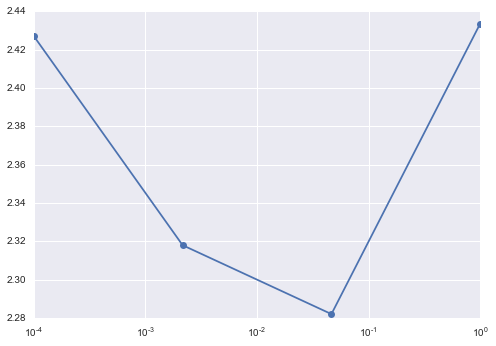

In [78]:
#Look at different c values to determine effects on predictions in logistic regression
ranges = np.logspace(-4,0,4)
res = []
for C in ranges:
    
    res.append(score(LogisticRegression(C = C)))
    
plt.semilogx(ranges, res,'-o');
print(res)

In [79]:
#Looks like the best value is somewhere around 0.02
cvals = [0.01, 0.013, 0.019, 0.02, 0.023, 0.29, 0.03]
scores=[]
for c in cvals:
    scores.append(score(LogisticRegression(C = c)))
print(scores)

[2.2848754720951452, 2.2822016661018623, 2.279878383549705, 2.2797072678798029, 2.2794173650602771, 2.3345948911191665, 2.2796067324925864]


In [80]:
#Looks like .023 is narrowed down sufficient to generate a solution file for the first run
score(LogisticRegression(C=0.023, multi_class='multinomial',solver='lbfgs'))

2.2738866627109089

In [81]:
clf = LogisticRegression(C=0.023, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)

prediction = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)
prediction.head(n=10)

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.001245,0.005721,0.012861,0.012037,0.024331,0.042985,0.011307,0.031796,0.072602,0.117752,0.259899,0.407463
-1547860181818787117,0.007344,0.012923,0.031140,0.056959,0.071482,0.149496,0.005435,0.093069,0.055558,0.074647,0.237918,0.204030
7374582448058474277,0.023752,0.037433,0.035714,0.160337,0.160441,0.076560,0.013176,0.026205,0.043130,0.102588,0.187902,0.132764
-6220210354783429585,0.003190,0.031913,0.008346,0.012010,0.051401,0.175574,0.047242,0.137787,0.072379,0.091120,0.179105,0.189932
-5893464122623104785,0.045832,0.066375,0.042068,0.062492,0.055551,0.042399,0.088834,0.167643,0.099756,0.102610,0.133955,0.092485
-7560708697029818408,0.045832,0.066375,0.042068,0.062492,0.055551,0.042399,0.088834,0.167643,0.099756,0.102610,0.133955,0.092485
289797889702373958,0.059790,0.060136,0.042424,0.066462,0.077386,0.058109,0.102419,0.123285,0.078022,0.100734,0.124937,0.106296
-402874006399730161,0.059790,0.060136,0.042424,0.066462,0.077386,0.058109,0.102419,0.123285,0.078022,0.100734,0.124937,0.106296
5751283639860028129,0.052106,0.065082,0.041886,0.069876,0.083793,0.068673,0.072148,0.128918,0.077280,0.097636,0.142700,0.099903


In [82]:
prediction.to_csv('my_submission(logi).csv',index=True)